This is an [jupyter](http://jupyter.org) notebook.
Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

Open the notebook by (1) copying this file into a directory, (2) in that directory typing 
jupyter-notebook
and (3) selecting the notebook.

***
Written By: **Riddhish Bhalodia**
***

In this exercise, we will learn and code about Kalman Filtering and look at few of it's applications.

# Kalman Filtering
## Motivation

Let me start it this way that before Rudolf Kalman (co-inventor of Kalman filtering), problems were divided in two distinct classes *Control Problems* (what value of acceleration should be provided to the car so that it climbes a certain incline with constant speed) and *Filtering Problem* (damn this noisy accelerometer, I can't get a clear value even at a fized point). 

You might have guessed (if you care to read the brackets :P) that the two problems are not uncorellated. To the un-initiated, take a senario that the car has a noisy accelerometer and you want to control it's speed on the incline, so two problems in one. One way is to solve them independently, but that is too situation dependent and so there was a need for a *dynamic solution* for *filtering while controlling and vice versa*, essentially bringing the two seperate problems under one roof.

This is presicely what Kalman Filter does! Kalman Filter and it's non-linear extensions are essential elements in modern control theory. Lot of different applications ranging from filtering noisy sensor output to autonomous robot navigation uses Kalman Filter.

In this tutorial we will first start off with an application, which we will code (yay!) and then move on to buld Kalman filtering theory.


## Faulty Voltmeter


A classic example to start with and very intuitive. We have to measure a DC voltage from a faulty (noisy) voltmeter, it cant get any simpler than this.
First off let's import certain packages

In [4]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import random

Now for solving any computational problem we need to model the *system* (in layman terms, set of equations which is used to describe the overall situation and how it varies with physical inputs and parameters).
The simplest way to model the noisy voltmeter at *every measurenment instant* is through the following equation
\begin{equation}
V_m = V_{m-1} + \omega_m \qquad (1)
\end{equation}

Here, $V_m$ : Voltage at current time,
      $V_{m-1}$ : Voltage at previous time instant,
      $\omega_m$ : Random Noise (process noise)
      
We also have measurenments taken at each instance m which is given by $Z_m$ and is corrupted by some sensor (measurenment) noise $\nu_m$

$$Z_m = V_m + \nu_m \qquad (2)$$

Usually in such cases as $\nu_m$ is introduced due to faults in voltmeter (sensor) and hence we usually know it's characteristics (least count, precision ... ring any bells?). So here we will model $\nu_m$ as a Gaussian Random Variable (as it is usually done) with zero mean and standard deviation $\sigma_{\nu} = 0.3$ (for simulation sake). $\omega_m$ is more difficult to predict and is introduced by error due to non-ideality (we know it's constant DC voltage, but is it really!) of our process equations but we still assume that we know it. Again, $\omega_m$ is to be modelled by a Gaussian Random Variable with zero mean and standard deviation $\sigma_{\omega} = 0.01$.

So before solving this let's model this voltmeter, What are the parameters to give. The true constant voltage lets say variable `true_voltage = 1`, and we need a noise level as well (this is voltmeter's error so will feature in measurenment error), say variable `noise_level_sig = 0.2` (KF works when noise estimate are off by a mark...). Let's take measurenments for 50 instances store it in `iter_max` and we will generate the measurenment for each instant which will be just $~ \mathcal{N}(true\_voltage,noise\_level\_sig)$ (Think about this :))

In [5]:
true_voltage = 1
noise_level_sig = 0.2
iter_max = 50
measurenments = []
true_voltage_mat = []

for i in range(iter_max):
    measured = random.gauss(true_voltage , noise_level_sig)
    measurenments.append(measured)
    true_voltage_mat.append(true_voltage)


Let's plot how the measurnments look as compared to the true voltage

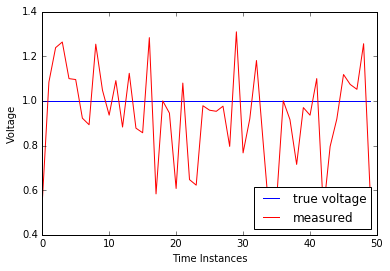

In [6]:
plt.plot(range(iter_max),true_voltage_mat,'b',range(iter_max), measurenments,'r')
plt.xlabel('Time Instances')
plt.ylabel('Voltage')
plt.legend(('true voltage', 'measured'), loc=4)

Now starts the actual thing, we want to filter this :D, by using Kalman Filtering. But first we need to derive, so do get ready for a chunk load of theory, but but please be paitient as once we are done with this, the standard Kalman Filter will be a piece of cake
:)

### Filtering!!


Math Math Math.

That being said, to solve this problem iteratively we need two major step

* Predict the voltage at next instance using the previous estimate (1)
* Correct the estimate based on the measurenment at that instant 

So we define two variables, $\hat{V}^-_m :$ *prior* estimate of the voltage given only the knowledge of the process (the equation (1)) and $\hat{V}_m :$ *posterior* estimate of the voltage at step m given the knowledge of the measurenment $Z_m$ 

So lets' start the firing of equations, just one comment before this, we will also estimate the error in the estimate at every iteration along with the estimate itself.

$$e_m = V_m - \hat{V}_m \quad \textrm{and} \quad \sigma^2_m = \mathbb{E}[e_m^2]$$

and 

$$e^-_m = V_m - \hat{V}^-_m \quad \textrm{and} \quad \sigma^{2-}_m = \mathbb{E}[e_m^{2-}]$$

We have to minimize this $\sigma^2_m$. So now as any sane person (ok statistician) would do we would model the *posterior* estimate $\hat{V}_m$ as the linear combination of the *prior* estimate $\hat{V}^-_m$ and the deviation of the estimate from the measurenment (also called as *innovation term*) given as

$$y_m = Z_m - \hat{V}^-_m \qquad (3)$$


Putting the above ramble in equation we have 

$$\hat{V}_m = \hat{V}^-_m + k_my_m \qquad (4)$$

subtracting $V_m$ from both sides we get

$$\hat{V}_m - V_m = \hat{V}^-_m - V_m + k_m(Z_m - \hat{V}^-_m)$$

To compute $k_m$ we take the square and it's expectation and then differentiate the quadratic in $k_m$ to get something like (try this your self)

$$k_m = \frac{\mathbb{E}[(V_m - \hat{V}^-_m)(y_m)]}{\mathbb{E}[y_m^2]}$$

The numerator and denominator when expanded and taking into the account for independence of the R.V $Z_m$, $V_m$, and $\hat{V}^-_m$ (think about this too) we get 

$$k_m = \frac{\sigma^{2-}_m}{\sigma^{2-}_m + \sigma^2_{\nu}} \qquad (5)$$

along with this we also have from equation(1) 

$$\sigma_m^{2-} = \sigma_{m-1}^2 + \sigma_\omega^2 \qquad (6)$$

Now substituting this (5) in the quadratic for $\mathbb{E}[e^2_m]$ we get the variance as

$$\sigma^2_m = (1 - k_m)\sigma_m^{2-} \qquad (7)$$

Now we have everything :D, already! It will be clear when you look at the summary below
* Start with an initial guess for $V = V_0$
* Get the *prior* estimate of voltage and it's error ($\hat{V}^-_m$ and $\sigma_m^{2-}$) from the process equation (1) and (6)
* Using the *prior* estimates and the measurnement data at instant m we get the *posterior* (read corrected) estimates of the voltage and it's error at instant m ($\hat{V}_m$ and $\sigma_m^2$)
* Repeat this for several instances and we will converge to a solution (Yes! there exist a proof for convergence, you can google it up)

So hopefully you would have gotton a hang of how this works. So let's code it up

In [7]:
# Initialize the parameters

initial_guess = 3
initial_guess_error = 1
sig_nu = 0.3
sig_omega = 0.01
estimate_vector = []
estimate_vector.append(initial_guess)
error_estimate_vector = []
error_estimate_vector.append(initial_guess_error)

# Run the Filter

for i in range(iter_max-1):
    # first the prior estimation step
    
    volt_prior_est = estimate_vector[i]
    error_prior_est = error_estimate_vector[i] + sig_omega * sig_omega
    
    # estimate correction
    
    k = error_prior_est/(error_prior_est + sig_nu * sig_nu)
    volt_corrected_est = volt_prior_est + k * (measurenments[i+1] - volt_prior_est)
    error_corrected_est = (1 - k) * error_prior_est
    estimate_vector.append(volt_corrected_est)
    error_estimate_vector.append(error_corrected_est)
    

Let us plot the things

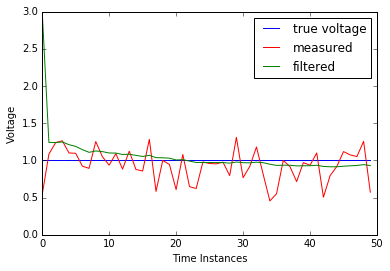

In [8]:
plt.figure()
plt.plot(range(iter_max),true_voltage_mat,'b',range(iter_max), measurenments,'r', range(iter_max), estimate_vector,'g')
plt.xlabel('Time Instances')
plt.ylabel('Voltage')
plt.legend(('true voltage', 'measured', 'filtered'), loc=1)

Did you have your voila moment? :D
Lets also look at the error for the estimate, lets plot it.


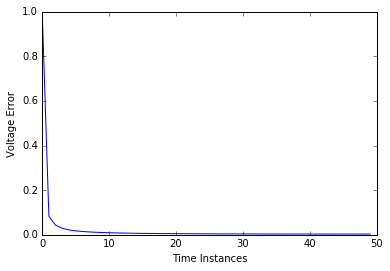

In [9]:
plt.figure()
plt.plot(range(iter_max),error_estimate_vector)
plt.xlabel('Time Instances')
plt.ylabel('Voltage Error')

## Kalman Filter

You might be wondering where is the control in all this. So now thats easily introduced in the actual formulation of Kalman filter which we will look at now. In the actual Kalman Filter we deal with multi-variable seting unlike that of the voltmeter example. So let me describe the inputs and the outputs and the parameters

**Inputs**
* $\textbf{Z}_m : $ The measurenment vector at each instant m
* $\textbf{U}_m : $ *This is new!*, it denotes the controls provided to the system at instance m (this is just like force being the control for velocity of the car)

**Outputs**
* $\textbf{X}_m : $ Newest estimate of the current state (state can be thought of as a parameter vector)
* $P_m :$ The newest estimate for the everage error of the state

**Parameters**
* A : State transition matrix, basically the constant matrix multiplied to the previous estimate in the process equation
* B : Control matrix, one to be multiplied to the control vector in the process equation
* H : Observation matrix, the proportionality factor for state to be equal to the measurenment
* Q : Covariance matrix for the process error (this is again assumed to be known)
* R : Covariance matrix for the measurenment error (again known)



Now we are ready to write the basic equations for the KF, don't worry much of the above will be cleared as you look at the equation.

Lets start with the two basic equations, first is the process equation

$$\textbf{X}_m = A\textbf{X}_{m-1} + B\textbf{U}_{m-1} + \pmb{\omega}_m \qquad (8)$$

and then we have the measurenment equation

$$\textbf{Z}_m = H\textbf{X}_m + \pmb{\nu}_m \qquad (9)$$

Here, we model the two error terms $\pmb{\omega}_m$ and $\pmb{\nu}_m$ as multi-variate Gaussian distributions with zero mean and covariance matrices Q and P respectively, i.e. $\pmb{\omega}_m \textrm{~} \mathcal{N}(0,Q)$
and $\pmb{\nu}_m \textrm{~} \mathcal{N}(0,P)$

So now following the exact same philosophy of that we followed for the derivation in voltmeter example we get the update equations for the general Kalman Filter. I will just list it down, if people are interested they can look up the references given below

$$ P_m^- = AP_{m-1}A^T + Q \qquad (10) $$

$$ K_m = P_m^-H^T(HP_m^-H^T + R) \qquad (11) $$

$$\pmb{y}_m = \pmb{Z}_m - H\hat{\pmb{X}_m^-} \qquad (12)$$

$$ \hat{\pmb{X}}_m = \hat{\pmb{X}_m^-} + K_m\pmb{y}_m \qquad (13)$$

$$ P_m = (I - K_mH)P_m^- \qquad (14)$$

Again summarizing

* Start with an initial guess for $\pmb{X} = \pmb{X}_0$
* Get the *prior* estimate of state and it's error ($\hat{\pmb{X}}^-_m$ and $P_m^{-}$) from the process equation (1) and (6)
* Using the *prior* estimates and the measurnement data at instant m we get the *posterior* (read corrected) estimates of the voltage and it's error at instant m ($\hat{V}_m$ and $\sigma_m^2$)
* Repeat this for several instances and we will converge to a solution (Yes! there exist a proof for convergence, you can google it up)

Now enough of this rambling, I do hope you get this but we are going to make a kalman filter class and then try to see how this fits with our voltmeter example. So lets first create a class

In [16]:
class kalmanFilter:
    def __init__(self, X0, P0, A, B, H, Q, R):
        self.A = A                       # State Transition Matrix
        self.B = B                       # Control Matrix
        self.H = H                       # Observation Matrix
        self.Q = Q                       # Covariance for the process error
        self.R = R                       # Covariance for the measurenment error
        self.current_estimate = X0       # this is the initial guess of the state
        self.current_error_estimate = P0 # initial guess for the state estimate error
        
    def getEstimate(self):
        # returns the current state estimate
        return self.current_estimate
    
    def getErrorEstimate(self):
        # returns the current state error estimate
        return self.current_error_estimate
    
    def iteration(self, U, Z):
        # here is where the updates happen
        # U = control vector
        # Z = measurenment vector
        
        # prior prediction step
        prior_estimate = self.A * self.current_estimate + self.B * U
        prior_error_estimate = (self.A * self.current_error_estimate) * np.transpose(self.A) + self.Q
        
        # intermediate observation
        y = Z - self.H * prior_estimate
        y_covariance = self.H * prior_error_estimate * np.transpose(self.H) + self.R
        
        # Correction Step
        K = prior_error_estimate * np.transpose(self.H) * np.linalg.inv(y_covariance)
        self.current_estimate = prior_estimate + K * y
        # We need the size of the matrix so we can make an identity matrix.
        size = self.current_error_estimate.shape[0]
        # eye(n) = nxn identity matrix.
        self.current_error_estimate = (np.eye(size) - K * self.H) * prior_error_estimate


Now we have this nice class set up, let's test it's correcteness by applying it to the Voltmeter problem. First things in the voltmeter problem we set the parameters first.

In [19]:
A = np.matrix([1])
B = np.matrix([0])
H = np.matrix([1])
Q = np.matrix([0.0001]) # the sigmas gets squared
R = np.matrix([0.09])
X0 = np.matrix([3])
P0 = np.matrix([1])

KF = kalmanFilter(X0, P0, A, B, H, Q, R)
estimate_vector_new = []
estimate_vector_new.append(initial_guess)
error_estimate_vector_new = []
error_estimate_vector_new.append(initial_guess_error)

# Run the Filter

for i in range(iter_max-1):
    U = np.matrix([0]) # there is no control here
    Z = np.matrix([measurenments[i+1]])
    estimate_vector_new.append(KF.getEstimate()[0,0])
    error_estimate_vector_new.append(KF.getErrorEstimate()[0,0])
    KF.iteration(U,Z)
    

Now lets plot again to see weather we are good to go or not.

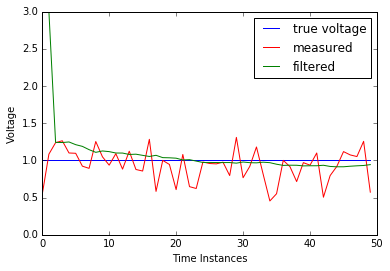

In [20]:
plt.figure()
plt.plot(range(iter_max),true_voltage_mat,'b',range(iter_max), measurenments,'r', range(iter_max), estimate_vector_new,'g')
plt.xlabel('Time Instances')
plt.ylabel('Voltage')
plt.legend(('true voltage', 'measured', 'filtered'), loc=1)

Well it should exaclty match with the previous plot :P duh, big deal. But now as we have this nice class we can start dealing with cooler application. So now after much search I have come up with this application to end this hopefully interesting notebook :D